<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

# Load Task Table from binary file

### Description:
This script tests uploading of Task Table from binary file (instead of dedicate scpi commands)

This script creates two segment in the generator:
SEG1 - mid level DC data
SEG2 - sinus data
The task that will play SEG1 and SEG2 in an infinite loop. task2 that plays SEG2 will isue a trigger to the ADC.

The ADC will show the generated signal (If module does not include ADC, signal can be tested on scope)

### set up:
It is recommended to have a AWT device with 4 channels and Digitizer such as P9484M.
This scripts supports connection via LAN and PXI
Connect channels 1 and 2 of the generator to channels 1 and 2 of the digitizer respectively.


### Proteus version: 
Anabelle

In [1]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

In [2]:
import os
import gc
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst

### Before we start

This example is designed to work both when there is a LAN based communication-service (usually on benchtop/desktop)<br>
And when there's no communication-service, and the user's application has access to hardware-modules in the PXI chassis.

In the first case, when there's a LAN communication, this example uses the class `TEVisaInst` from `tevisainst`.<br>

In the second case, this example uses the classes `TEProteusAdmin` and `TEProteusInst` from `teproteus`.

In [3]:
# Connect to instrument

inst = None
admin = None

conn_msg_str = ''

def disconnect():
    global inst
    global admin
    if inst is not None:
        try:
            inst.close_instrument()            
        except:
            pass
        inst = None
    if admin is not None:
        try:
            admin.close_inst_admin()
        except:
            pass
        admin = None
    gc.collect()

def connect_to_pxi_slot(slot_id):
    global inst
    global admin
    try:
        disconnect()        
        admin = TEProteusAdmin()
        admin.open_inst_admin()        
        inst = admin.open_instrument(slot_id, reset_hot_flag=True)
    except:
        pass

def connect_to_lan_server(ip_address):
    global inst
    try:
        disconnect()
        inst = TEVisaInst(ip_address, port=5025)
    except:
        pass

def connect(ipaddr_or_slotid):
    try:
        disconnect()
        if isinstance(ipaddr_or_slotid, str) and '.' in ipaddr_or_slotid:
            connect_to_lan_server(ipaddr_or_slotid)
        else:
            connect_to_pxi_slot(ipaddr_or_slotid)
    except:
        pass

addr_textbox = widgets.Text(
    value='',
    placeholder='IP Address or Slot Id',
    description='Address:',
    disabled=False
)

output = widgets.Output()

def print_conn_message(msg_str):
    global output
    global conn_msg_str
    with output:
        if len(conn_msg_str) > 0:
            print('\r', end='')
            print(' ' * len(conn_msg_str), end='')
            print('\r', end='')
        conn_msg_str = str(msg_str)
        if len(conn_msg_str) > 0:
            print(conn_msg_str, end='')

def on_button_connect_clicked(b):
    global inst
    global addr_textbox
    print_conn_message('')
    disconnect()
    if addr_textbox is not None:
        conn_str = addr_textbox.value
        if conn_str:
            print_conn_message('Connecting to {0} ..'.format(conn_str))
            connect(conn_str)
            print_conn_message('')
    if inst is not None:
        idn_str = inst.send_scpi_query('*IDN?')
        if idn_str:
            print_conn_message('Connected to: ' + idn_str.strip())
    
def on_button_disconnect_clicked(b):
    print_conn_message('')
    disconnect()

btn_connect = widgets.Button(description="Connect")
btn_disconnect = widgets.Button(description="Disconnect")

btn_connect.on_click(on_button_connect_clicked)
btn_disconnect.on_click(on_button_disconnect_clicked)

display(addr_textbox, btn_connect, btn_disconnect, output)

Text(value='', description='Address:', placeholder='IP Address or Slot Id')

Button(description='Connect', style=ButtonStyle())

Button(description='Disconnect', style=ButtonStyle())

Output()

In [4]:
connect('192.168.0.117')
# Paranoia Level (0: low, 1: normal, 2: debug)
paranoia_level = 2

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.send_scpi_query(':SYST:INF:DAC?')

if resp == 'M0': 
    dac_mode=16 
else: dac_mode=8

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

if model_name.startswith('P948'):
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 1
elif model_name.startswith('P908'):
    bpp = 1
    max_dac = 255
    wpt_type = np.uint8
    offset_factor = 1
else:
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 2
    
half_dac = max_dac / 2.0    
    
print('DAC {0} bits'.format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0


# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Tabor Electronics,P9484M,000000000000,1.234.0 --slot#: 5, 
Model: P9484M 
DAC 16 bits
0, no error


# Configure Generator

#### Create Two segments

In [5]:
# Build two AWG segment that will be used as innput for the digitizer

cycleLen = 1024
numCycles = 1
segLen = cycleLen * numCycles

# build DC level segment
d = np.full((1,segLen),half_dac)
d = d.astype(data_type)


# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')
# download the waveform to the selected segment
cmd = '*OPC?; :TRAC:DATA'
inst.write_binary_data(cmd, d[0])
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


cycleLen = 1024
numCycles = 8
segLen = cycleLen * numCycles

# Build waveform (sine wave)
x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)

y = (np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 2,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 2')
# download the waveform to the selected segment
cmd = '*OPC?; :TRAC:DATA'
inst.write_binary_data(cmd, y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd('SOUR:VOLT 0.5')

0, no error
0, no error


0

#### Import Task table from a file

In [6]:
######### import TASK table from a file ##############################
# The default directory is: 'C:\Users\<user-name>\Documents\ProteusFiles'
task_table_path = 'TaskTableBinaryFile.bin'

# Alternatively use absolute path:
mypath = os.path.realpath('.')
task_table_path = os.path.join(mypath, task_table_path)
print('task_table_path: "{0}"'.format(task_table_path))

# Convert the string to byte-array
str_bytes = np.frombuffer(task_table_path.encode(), dtype=np.uint8)

# Select task-table-file
inst.write_binary_data(':TASK:FILE', str_bytes)

# Load task table from the selected file:
inst.send_scpi_cmd(':TASK:FILE:LOAD')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# set task mode
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:TASK 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:TYPE TASK')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

task_table_path: "C:\Users\Proteus\Desktop\ProteusScripts\Anabelle\Python\Examples\Notebooks\Task Table\TaskTableBinaryFile.bin"
0, no error
0, no error


#### DAC clock and output

In [7]:
# change DAC clock

if dac_mode == 16: 
    MaxSclk=2.5e9 
else:
    MaxSclk=9e9

print(dac_mode)    
    
cmd = ':SOUR:FREQ {0}'.format(MaxSclk)
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# AWG Channl 1 (output) should be connected to Digitizer Channel 1 (input)
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':OUTP ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

16
0, no error
0, no error


## ADC Single channel

In [8]:
# Setup the digitizer in single-channels mode
inst.send_scpi_cmd(':DIG:MODE SING')
inst.send_scpi_cmd(':DIG:FREQ 5400MHZ')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the TASK1 as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

# Enable capturing data from channel 2
#inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
#inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
#inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')

# Allocate four frames of 4800 samples
numframes, framelen = 4, 19200
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [9]:
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

time.sleep(1)

# Query the status. a poling should be done here till end of capturing.
# the delay above is sufficient for capturing 4 frames
resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
print(resp)

# Stop the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

1,1,0,4
0, no error


In [10]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print('================')
print(wav1)

Total size in bytes: 153600

0, no error
[2047 2054 2039 ...  679  682  688]


<IPython.core.display.Javascript object>


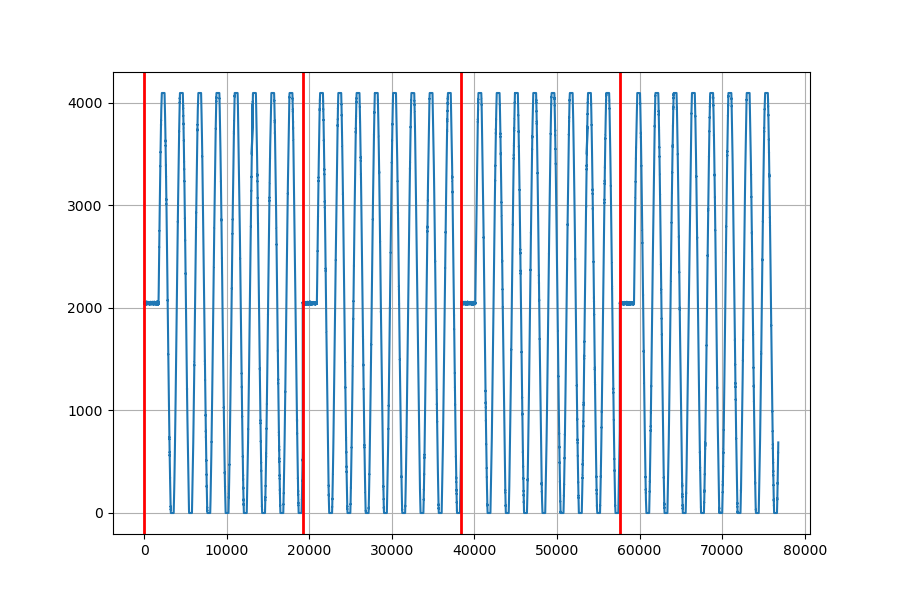

2069 1741
Delay is: 696.4 nS
0, no error
0, no error


In [11]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
v = np.linspace(0,totlen,numframes,endpoint=False)
plt.figure(figsize=(9,6))
plt.grid(True)
plt.plot(x, wav1)

# find position of sinus start, showing the system delay in DAC samples
# delay is between trigger to the ADC until the sinus signal arrives and measured.
previous = 2042
for i in x:
    if(abs(wav1[int(i)] - previous) > 25 ):
        print(wav1[int(i)], i)
        print(f'Delay is: {i / MaxSclk * 1e9} nS')
        break

for xv in v:
    plt.axvline(x=xv,linewidth=2,color='red')

plt.show()

del wav1

# Clear Frames

cmd = ':DIG:ACQ:ZERO:ALL'
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

#free memory

cmd = ':DIG:ACQ:FREE'
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

## End

In [12]:
# close connection
disconnect()